# Разведочный анализ данных (EDA) датасета Elliptic++

**Цель анализа:** исследовать датасет Elliptic++ для выявления закономерностей, которые помогут в построении самообучающейся системы для выявления аномальных транзакций в сети блокчейн.

## 1. Загрузка необходимых библиотек

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 2. Загрузка данных

### 2.1 Описание данных Elliptic++

Датасет Elliptic++ содержит данные о транзакциях Bitcoin и кошельках (адресах). Он включает следующие файлы:

**Транзакции (transactions):**
- **txs_features.csv** – 203 769 строк, по 183 исходных признака (включая "временной шаг", 93 локальных признака и 72 агрегированных) плюс 17 дополнительных, рассчитанных в расширении Elliptic++ (например, суммарный BTC_in/BTC_out, число входящих/исходящих транзакций, число адресов, размер транзакции, комиссии)
- **txs_classes.csv** – метка каждого узла-транзакции: 1 = illicit (незаконные), 2 = licit (законные), 3 = unknown (неизвестные)
- **txs_edgelist.csv** – ориентированные рёбра «транзакция → транзакция», задающие поток средств

**Акторы (wallet addresses):**
- **wallets_features.csv** – 822 942 адреса, по 56 признаков: статистика отправленных/полученных BTC, комиссии, временные интервалы между операциями, число взаимодействий с другими адресами и т.д.
- **wallets_classes.csv** – метка каждого адреса (illicit/licit/unknown) на основе его связей с помеченными транзакциями
- **AddrAddr_edgelist.csv** – рёбра «адрес → адрес» через общие транзакции
- **AddrTx_edgelist.csv** – рёбра «адрес → транзакция»
- **TxAddr_edgelist.csv** – рёбра «транзакция → адрес»

In [3]:
# Загружаем данные о транзакциях
tx_features = pd.read_csv('data/elliptic-bitcoin/transactions/txs_features.csv')
tx_classes = pd.read_csv('data/elliptic-bitcoin/transactions/txs_classes.csv')
tx_edgelist = pd.read_csv('data/elliptic-bitcoin/transactions/txs_edgelist.csv')

# Загружаем данные о кошельках (адресах)
wallet_features = pd.read_csv('data/elliptic-bitcoin/actors/wallets_features.csv')
wallet_classes = pd.read_csv('data/elliptic-bitcoin/actors/wallets_classes.csv')
addr_tx_edgelist = pd.read_csv('data/elliptic-bitcoin/actors/AddrTx_edgelist.csv')
tx_addr_edgelist = pd.read_csv('data/elliptic-bitcoin/actors/TxAddr_edgelist.csv')

In [4]:
# Проверяем размеры загруженных данных
print(f"Транзакции (характеристики): {tx_features.shape}")
print(f"Транзакции (классы): {tx_classes.shape}")
print(f"Транзакции (связи): {tx_edgelist.shape}")
print("\nКошельки:")
print(f"Кошельки (характеристики): {wallet_features.shape}")
print(f"Кошельки (классы): {wallet_classes.shape}")
print(f"Связи адрес-транзакция: {addr_tx_edgelist.shape}")
print(f"Связи транзакция-адрес: {tx_addr_edgelist.shape}")

Транзакции (характеристики): (203769, 184)
Транзакции (классы): (203769, 2)
Транзакции (связи): (234355, 2)

Кошельки:
Кошельки (характеристики): (1268260, 57)
Кошельки (классы): (822942, 2)
Связи адрес-транзакция: (477117, 2)
Связи транзакция-адрес: (837124, 2)


In [5]:
# Преобразуем данные о классах транзакций, добавляя понятные метки
tx_classes['label'] = tx_classes['class'].map({1: 'illicit', 2: 'licit', 3: 'unknown'})

# Объединяем признаки и классы транзакций
transactions = pd.merge(tx_features, tx_classes, on='txId')
transactions.head()

,txId,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,...,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total,class,label
0,3321,1,-0.169615,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160199,...,0.534072,0.534072,0.534072,1.668990e-01,0.367074,0.266986,0.266986,0.533972,3,unknown
1,11108,1,-0.137586,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.127429,...,5.611878,5.611878,5.611878,5.861940e-01,5.025584,2.805889,2.805889,5.611778,3,unknown
2,51816,1,-0.170103,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160699,...,0.456608,0.456608,0.456608,2.279902e-01,0.228518,0.228254,0.228254,0.456508,3,unknown
3,68869,1,-0.114267,-0.184668,-1.201369,0.028105,-0.043875,-0.113002,0.547008,-0.161652,...,3.102967,1.000000,9.308900,1.229000e+00,8.079800,4.654400,4.654400,9.308800,2,licit
4,89273,1,5.202107,-0.210553,-1.756361,-0.121970,260.090707,-0.113002,-0.061584,5.335864,...,852.164680,852.164680,852.164680,1.300000e-07,41.264036,0.065016,0.000441,852.164680,2,licit


In [6]:
# Добавляем метки классов к данным кошельков
wallet_classes['label_map'] = wallet_classes['class'].map({1: 'illicit', 2: 'licit', 3: 'unknown'})

# Объединяем признаки и классы кошельков
wallets = pd.merge(wallet_features, wallet_classes, on='address')
wallets.head()

,address,Time step,num_txs_as_sender,num_txs_as receiver,first_block_appeared_in,last_block_appeared_in,lifetime_in_blocks,total_txs,first_sent_block,first_received_block,...,blocks_btwn_output_txs_mean,blocks_btwn_output_txs_median,num_addr_transacted_multiple,transacted_w_address_total,transacted_w_address_min,transacted_w_address_max,transacted_w_address_mean,transacted_w_address_median,class,label_map
0,111112TykSw72ztDN2WJger4cynzWYC5w,25,0.0,1.0,439586.0,439586.0,0.0,1.0,0.0,439586.0,...,0.000000,0.0,0.0,24.0,1.0,1.0,1.0,1.0,2,licit
1,1111DAYXhoxZx2tsRnzimfozo783x1yC2,25,0.0,8.0,439589.0,485959.0,46370.0,8.0,0.0,439589.0,...,6624.285714,8060.0,0.0,8.0,1.0,1.0,1.0,1.0,3,unknown
2,1111DAYXhoxZx2tsRnzimfozo783x1yC2,29,0.0,8.0,439589.0,485959.0,46370.0,8.0,0.0,439589.0,...,6624.285714,8060.0,0.0,8.0,1.0,1.0,1.0,1.0,3,unknown
3,1111DAYXhoxZx2tsRnzimfozo783x1yC2,39,0.0,8.0,439589.0,485959.0,46370.0,8.0,0.0,439589.0,...,6624.285714,8060.0,0.0,8.0,1.0,1.0,1.0,1.0,3,unknown
4,1111DAYXhoxZx2tsRnzimfozo783x1yC2,39,0.0,8.0,439589.0,485959.0,46370.0,8.0,0.0,439589.0,...,6624.285714,8060.0,0.0,8.0,1.0,1.0,1.0,1.0,3,unknown


### 2.2 Проверка пропущенных значений

In [7]:
# Проверяем пропущенные значения в данных о транзакциях
missing_tx = tx_features.isnull().sum()
missing_tx = missing_tx[missing_tx > 0]
print(f"Общее количество пропущенных значений в транзакциях: {tx_features.isna().sum().sum()}")
print(f"Количество признаков с пропущенными значениями: {len(missing_tx)}")
if len(missing_tx) > 0:
    print("\nПризнаки с пропущенными значениями:")
    print(missing_tx)

Общее количество пропущенных значений в транзакциях: 16405
Количество признаков с пропущенными значениями: 17

Признаки с пропущенными значениями:
in_txs_degree           965
out_txs_degree          965
total_BTC               965
fees                    965
size                    965
num_input_addresses     965
num_output_addresses    965
in_BTC_min              965
in_BTC_max              965
in_BTC_mean             965
in_BTC_median           965
in_BTC_total            965
out_BTC_min             965
out_BTC_max             965
out_BTC_mean            965
out_BTC_median          965
out_BTC_total           965
dtype: int64


In [8]:
# Проверяем пропущенные значения в данных о кошельках
missing_wallets = wallet_features.isnull().sum()
missing_wallets = missing_wallets[missing_wallets > 0]
print(f"Общее количество пропущенных значений в кошельках: {wallet_features.isna().sum().sum()}")
print(f"Количество признаков с пропущенными значениями: {len(missing_wallets)}")
if len(missing_wallets) > 0:
    print("\nПризнаки с пропущенными значениями:")
    print(missing_wallets)

Общее количество пропущенных значений в кошельках: 0
Количество признаков с пропущенными значениями: 0


### 2.3 Очистка данных и заполнение пропущенных значений

In [9]:
# Заполняем пропущенные значения в данных о транзакциях медианными значениями
transactions_clean = transactions.copy()
for col in transactions.select_dtypes(include=['float64', 'int64']).columns:
    if transactions[col].isnull().sum() > 0:
        transactions_clean[col] = transactions[col].fillna(transactions[col].median())

print(f"Количество пропущенных значений после очистки: {transactions_clean.isnull().sum().sum()}")

Количество пропущенных значений после очистки: 0


## 3. Анализ данных транзакций

### 3.1 Распределение классов транзакций

Распределение транзакций по классам:
label
unknown    157205
licit       42019
illicit      4545
Name: count, dtype: int64

Процентное соотношение:
label
unknown    77.15
licit      20.62
illicit     2.23
Name: count, dtype: float64


/tmp/ipykernel_14585/4723134.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=transactions_clean, palette='viridis')


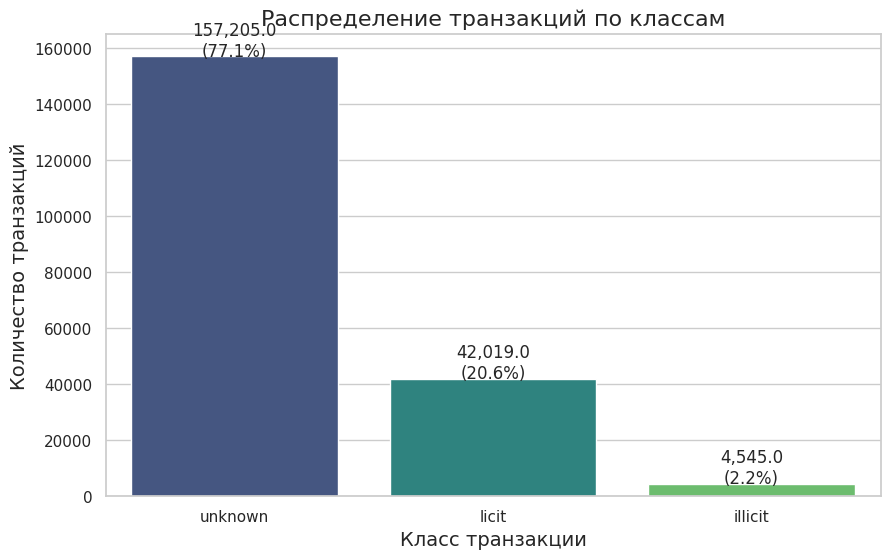

In [10]:
# Распределение транзакций по классам
class_counts = transactions_clean['label'].value_counts()
print("Распределение транзакций по классам:")
print(class_counts)
print("\nПроцентное соотношение:")
print((class_counts / len(transactions_clean) * 100).round(2))

# Визуализация распределения классов
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='label', data=transactions_clean, palette='viridis')
plt.title('Распределение транзакций по классам', fontsize=16)
plt.xlabel('Класс транзакции', fontsize=14)
plt.ylabel('Количество транзакций', fontsize=14)

# Добавляем подписи с количеством и процентами
total = len(transactions_clean)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.1, 
            f'{height:,}\n({height/total*100:.1f}%)',
            ha="center")
    
plt.show()

### 3.2 Анализ временных шагов

Количество временных шагов: 49


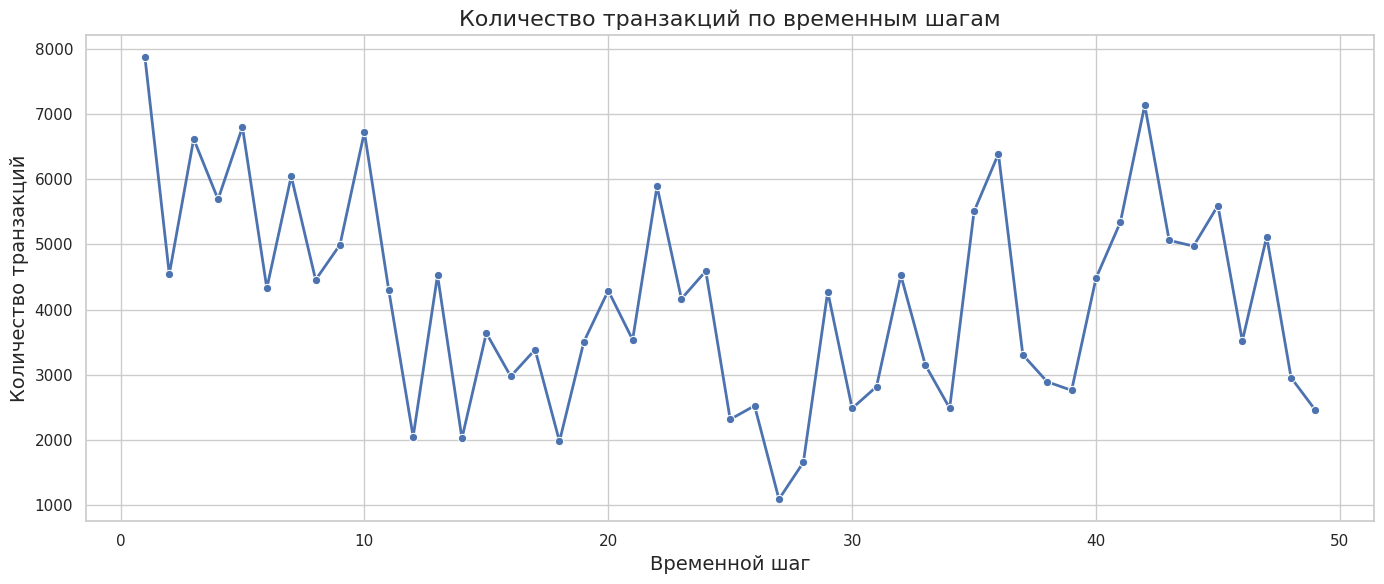

In [11]:
# Распределение транзакций по временным шагам
time_counts = transactions_clean['Time step'].value_counts().sort_index()
print("Количество временных шагов:", transactions_clean['Time step'].nunique())

plt.figure(figsize=(14, 6))
ax = sns.lineplot(x=time_counts.index, y=time_counts.values, marker='o', linewidth=2)
plt.title('Количество транзакций по временным шагам', fontsize=16)
plt.xlabel('Временной шаг', fontsize=14)
plt.ylabel('Количество транзакций', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

Распределение классов по временным шагам:
label      illicit  licit  unknown
Time step                         
1               17   2130     5733
2               18   1099     3427
3               11   1268     5342
4               30   1410     4253
5                8   1874     4921


<Figure size 1600x800 with 0 Axes>

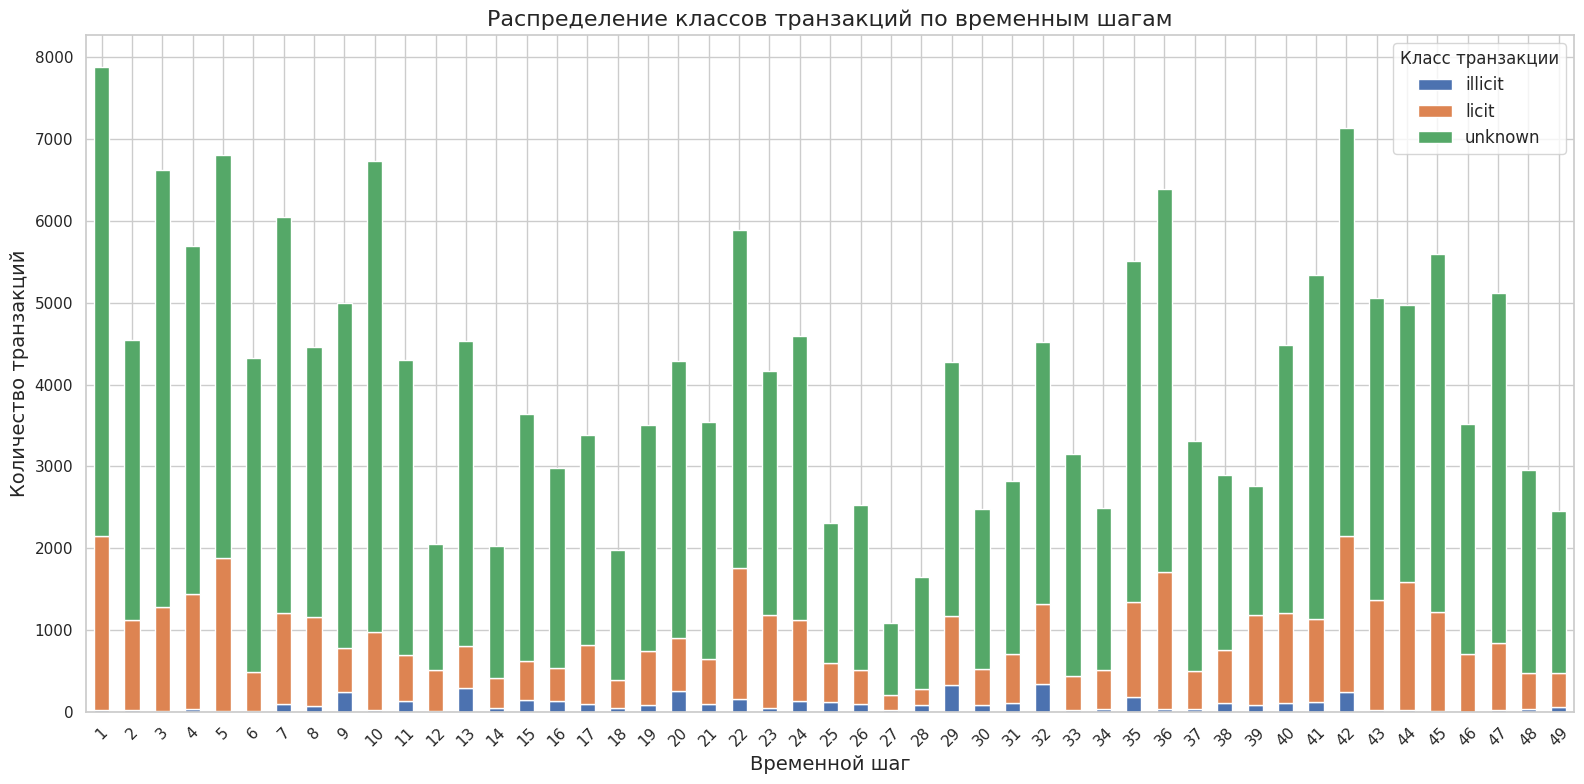

In [12]:
# Анализ распределения классов по временным шагам
time_class = transactions_clean.groupby(['Time step', 'label']).size().unstack(fill_value=0)
print("Распределение классов по временным шагам:")
print(time_class.head())

# Визуализация распределения классов по времени
plt.figure(figsize=(16, 8))
time_class.plot(kind='bar', stacked=True, figsize=(16, 8))
plt.title('Распределение классов транзакций по временным шагам', fontsize=16)
plt.xlabel('Временной шаг', fontsize=14)
plt.ylabel('Количество транзакций', fontsize=14)
plt.legend(title='Класс транзакции', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

### 3.3 Анализ признаков транзакций

In [13]:
# Выделяем дополнительные признаки транзакций (последние 17 столбцов)
add_features = transactions_clean.iloc[:, -20:-3]  # Исключаем txId, class и label
print("Дополнительные признаки транзакций:")
add_features.head()

Дополнительные признаки транзакций:


,Aggregate_feature_72,in_txs_degree,out_txs_degree,total_BTC,fees,size,num_input_addresses,num_output_addresses,in_BTC_min,in_BTC_max,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median
0,1.521399,1.0,0.0,0.533972,0.0001,225.0,1.0,2.0,0.534072,0.534072,0.534072,0.534072,0.534072,1.668990e-01,0.367074,0.266986,0.266986
1,-0.119792,1.0,1.0,5.611778,0.0001,225.0,1.0,2.0,5.611878,5.611878,5.611878,5.611878,5.611878,5.861940e-01,5.025584,2.805889,2.805889
2,-0.119792,1.0,1.0,0.456508,0.0001,226.0,1.0,2.0,0.456608,0.456608,0.456608,0.456608,0.456608,2.279902e-01,0.228518,0.228254,0.228254
3,-0.119792,0.0,1.0,9.308800,0.0001,853.0,3.0,2.0,0.308900,8.000000,3.102967,1.000000,9.308900,1.229000e+00,8.079800,4.654400,4.654400
4,-0.070977,1.0,288.0,852.164680,0.0000,445268.0,1.0,13107.0,852.164680,852.164680,852.164680,852.164680,852.164680,1.300000e-07,41.264036,0.065016,0.000441


In [14]:
# Статистика по дополнительным признакам
add_features_stats = add_features.describe()
print("Статистика по дополнительным признакам транзакций:")
add_features_stats

Статистика по дополнительным признакам транзакций:


,Aggregate_feature_72,in_txs_degree,out_txs_degree,total_BTC,fees,size,num_input_addresses,num_output_addresses,in_BTC_min,in_BTC_max,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median
count,2.037690e+05,203769.000000,203769.000000,203769.000000,203769.000000,203769.000000,203769.000000,203769.000000,2.037690e+05,203769.000000,203769.000000,2.037690e+05,203769.000000,203769.000000,203769.000000,203769.000000,203769.000000
mean,5.188658e-17,1.151829,1.152113,27.416985,0.000810,595.180768,2.624020,4.206248,2.534836e+01,26.623699,25.734731,2.564714e+01,27.417797,0.627899,26.385171,11.797764,11.310868
std,1.000002e+00,3.910844,1.893983,158.540103,0.003860,2795.792773,13.326524,50.377655,1.549535e+02,157.155882,155.126497,1.551189e+02,158.540191,10.965331,154.207078,66.956890,65.753641
min,-1.760984e+00,0.000000,0.000000,0.000006,0.000000,188.000000,1.000000,1.000000,1.000000e-08,0.000014,0.000014,1.000000e-08,0.000041,0.000000,0.000006,0.000006,0.000005
25%,-1.197925e-01,0.000000,1.000000,0.073287,0.000117,225.000000,1.000000,2.000000,2.009663e-02,0.062875,0.050450,4.200000e-02,0.073800,0.002744,0.059700,0.035926,0.027160
50%,-1.197925e-01,1.000000,1.000000,0.606105,0.000300,226.000000,1.000000,2.000000,2.500000e-01,0.515266,0.409314,3.580544e-01,0.606800,0.015000,0.500000,0.280447,0.215289
75%,1.199710e-01,1.000000,1.000000,6.489059,0.000600,373.000000,1.000000,2.000000,4.324206e+00,5.798777,4.931300,4.779278e+00,6.490106,0.100000,5.636576,2.578990,2.132623
max,1.521399e+00,284.000000,472.000000,11391.855937,0.285129,445268.000000,656.000000,13107.000000,1.139186e+04,11391.856516,11391.856516,1.139186e+04,11391.856516,2010.466695,11311.828314,2998.404230,2998.404230


In [15]:
# Сравнение ключевых признаков по классам транзакций
key_features = ['in_degree', 'out_degree', 'in_BTC_total', 'out_BTC_total', 'total_BTC', 'fees', 'size']
stats_by_class = transactions_clean.groupby('label')[key_features].agg(['mean', 'median', 'min', 'max', 'std'])
print("Статистика по ключевым признакам для разных классов транзакций:")
stats_by_class

KeyError: "Columns not found: 'out_degree', 'in_degree'"

ValueError: Could not interpret value `in_degree` for `y`. An entry with this name does not appear in `data`.

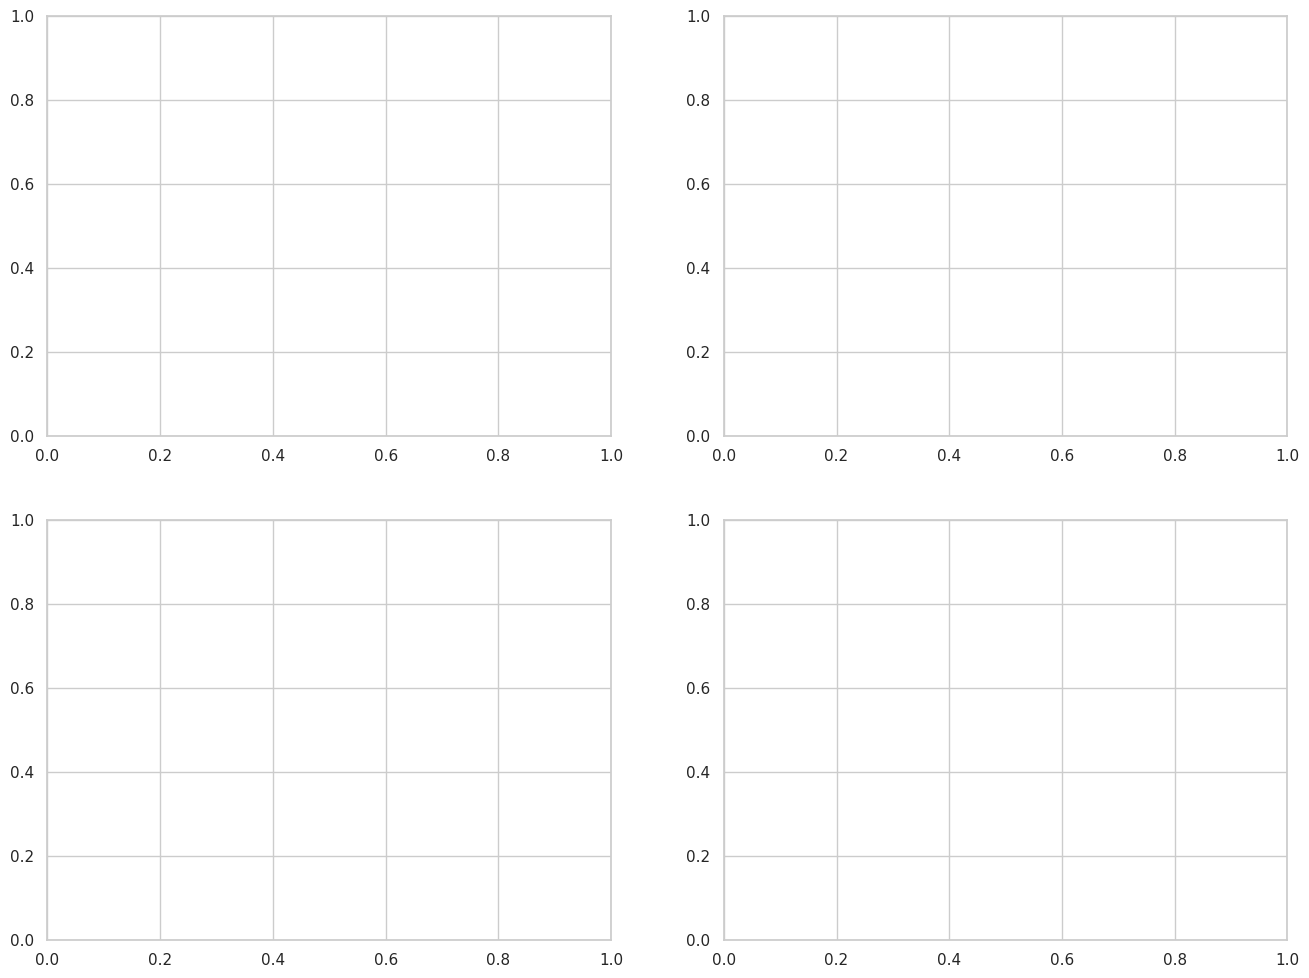

In [16]:
# Визуализация распределения ключевых признаков по классам
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, feature in enumerate(['in_degree', 'out_degree', 'in_BTC_total', 'out_BTC_total']):
    ax = axes[i]
    sns.boxplot(x='label', y=feature, data=transactions_clean, palette='viridis', showfliers=False, ax=ax)
    ax.set_title(f'Распределение {feature} по классам', fontsize=14)
    ax.set_xlabel('Класс транзакции', fontsize=12)
    ax.set_ylabel(feature, fontsize=12)
    ax.grid(True, axis='y')
    
plt.tight_layout()
plt.show()

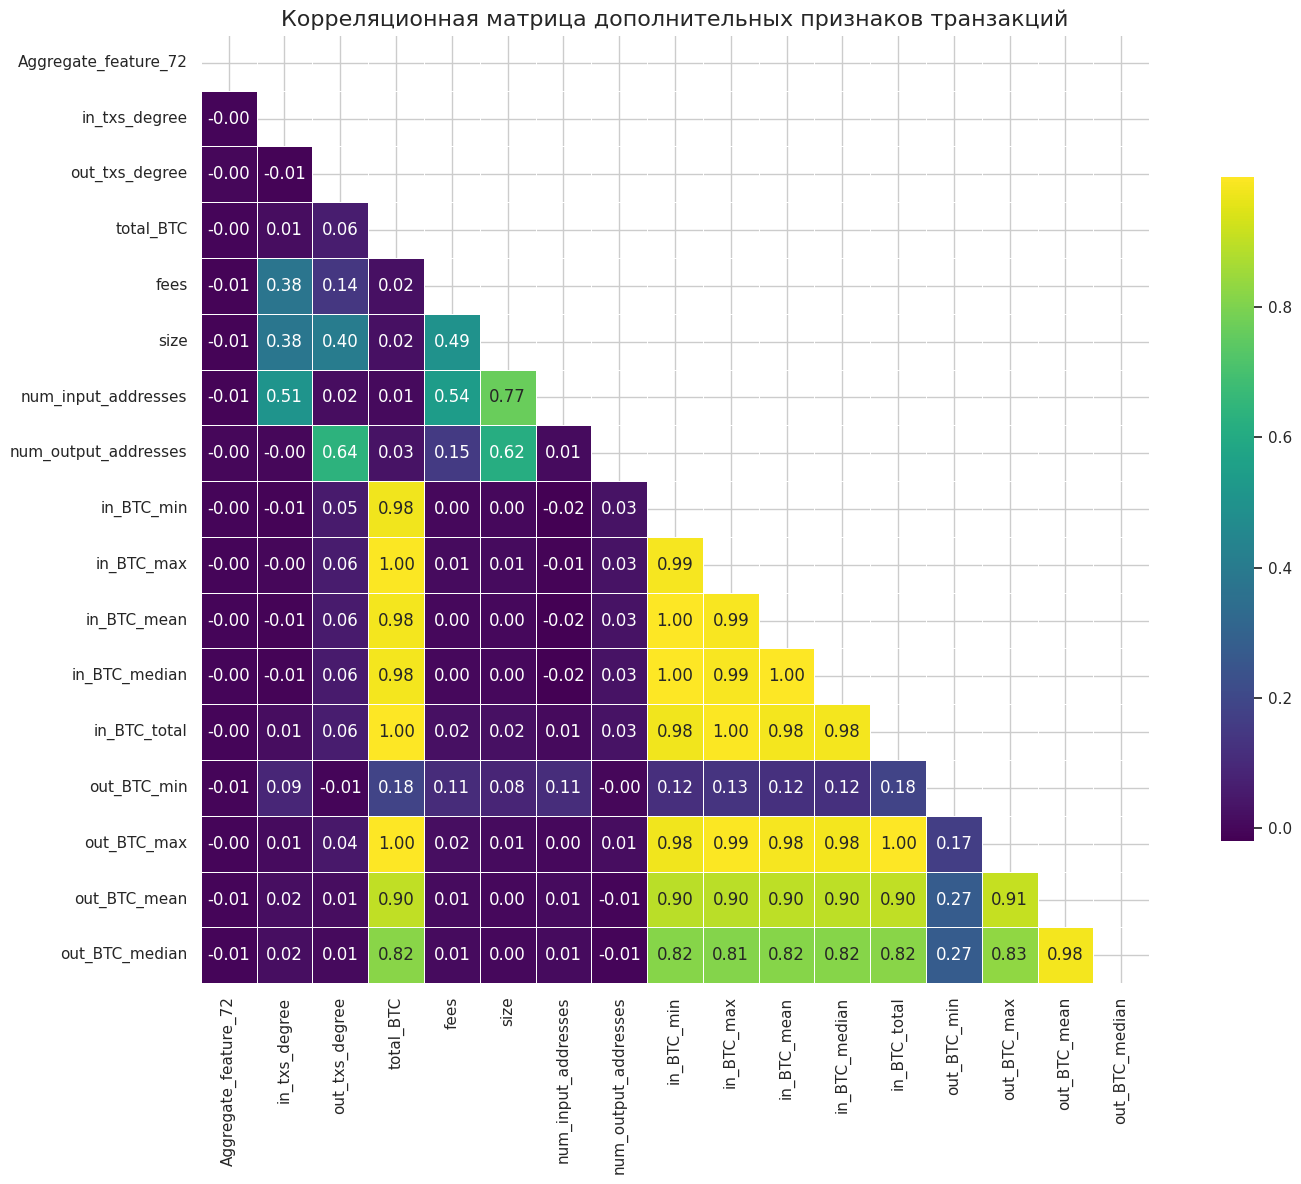

In [17]:
# Корреляционная матрица для дополнительных признаков
correlation_matrix = add_features.corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, cmap='viridis', annot=True, fmt='.2f', 
            square=True, linewidths=.5, cbar_kws={"shrink": .7})
plt.title('Корреляционная матрица дополнительных признаков транзакций', fontsize=16)
plt.tight_layout()
plt.show()

In [18]:
# Находим сильно коррелирующие признаки (|r| > 0.8)
high_correlations = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_correlations.append((
                correlation_matrix.columns[i], 
                correlation_matrix.columns[j], 
                correlation_matrix.iloc[i, j]
            ))

print("Сильно коррелирующие признаки (|r| > 0.8):")
for feat1, feat2, corr in sorted(high_correlations, key=lambda x: abs(x[2]), reverse=True):
    print(f"{feat1} и {feat2}: {corr:.3f}")

Сильно коррелирующие признаки (|r| > 0.8):
total_BTC и in_BTC_total: 1.000
in_BTC_mean и in_BTC_median: 1.000
in_BTC_min и in_BTC_median: 0.999
in_BTC_min и in_BTC_mean: 0.999
total_BTC и out_BTC_max: 0.996
in_BTC_total и out_BTC_max: 0.996
total_BTC и in_BTC_max: 0.995
in_BTC_max и in_BTC_total: 0.995
in_BTC_max и out_BTC_max: 0.995
in_BTC_max и in_BTC_mean: 0.990
in_BTC_max и in_BTC_median: 0.989
in_BTC_min и in_BTC_max: 0.985
in_BTC_mean и out_BTC_max: 0.985
total_BTC и in_BTC_mean: 0.983
in_BTC_mean и in_BTC_total: 0.983
in_BTC_median и out_BTC_max: 0.983
total_BTC и in_BTC_median: 0.982
in_BTC_median и in_BTC_total: 0.982
out_BTC_mean и out_BTC_median: 0.981
in_BTC_min и out_BTC_max: 0.980
total_BTC и in_BTC_min: 0.978
in_BTC_min и in_BTC_total: 0.978
out_BTC_max и out_BTC_mean: 0.910
total_BTC и out_BTC_mean: 0.902
in_BTC_total и out_BTC_mean: 0.902
in_BTC_mean и out_BTC_mean: 0.897
in_BTC_median и out_BTC_mean: 0.897
in_BTC_max и out_BTC_mean: 0.896
in_BTC_min и out_BTC_mean: 0.

### 3.4 Снижение размерности и визуализация данных

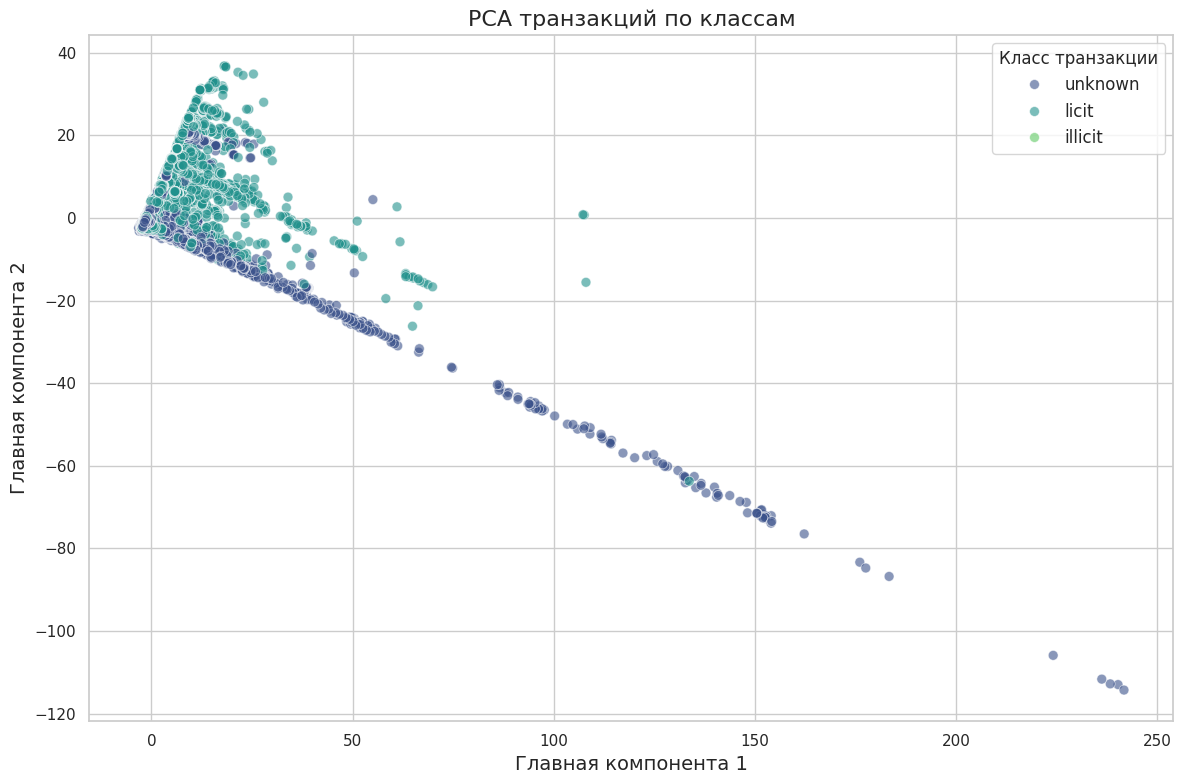

Объясненная дисперсия по компонентам: [0.10267893 0.09256405]
Суммарная объясненная дисперсия: 0.20


In [19]:
# Применяем PCA для визуализации данных
# Выбираем числовые признаки
numeric_features = transactions_clean.select_dtypes(include=['float64', 'int64'])
numeric_features = numeric_features.drop(['txId', 'class'], axis=1, errors='ignore')

# Стандартизация данных
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_features)

# Применяем PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

# Создаем датафрейм с результатами PCA
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['label'] = transactions_clean['label'].values

# Визуализируем результаты PCA
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='label', data=pca_df, palette='viridis', alpha=0.6, s=50)
plt.title('PCA транзакций по классам', fontsize=16)
plt.xlabel('Главная компонента 1', fontsize=14)
plt.ylabel('Главная компонента 2', fontsize=14)
plt.legend(title='Класс транзакции', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Информация о дисперсии, объясненной главными компонентами
explained_variance = pca.explained_variance_ratio_
print(f"Объясненная дисперсия по компонентам: {explained_variance}")
print(f"Суммарная объясненная дисперсия: {sum(explained_variance):.2f}")

## 4. Анализ данных кошельков (адресов)

### 4.1 Общая информация о кошельках

In [20]:
# Базовая информация о данных кошельков
print(f"Общее количество кошельков: {wallets.shape[0]}")
print(f"Количество признаков: {wallets.shape[1]-3}") # Исключаем address, class и label_map

# Проверяем количество пропущенных значений
missing_values_wallets = wallets.isnull().sum()
missing_percent_wallets = (missing_values_wallets / len(wallets)) * 100
missing_data_wallets = pd.DataFrame({'Missing Values': missing_values_wallets, 'Percent': missing_percent_wallets})
missing_data_wallets = missing_data_wallets[missing_data_wallets['Missing Values'] > 0]
print(f"\nКоличество признаков с пропущенными значениями: {len(missing_data_wallets)}")
if len(missing_data_wallets) > 0:
    print("Признаки с пропущенными значениями:")
    print(missing_data_wallets.sort_values('Percent', ascending=False))

Общее количество кошельков: 1268260
Количество признаков: 56

Количество признаков с пропущенными значениями: 0


Распределение кошельков по классам:
label_map
unknown    900788
licit      338871
illicit     28601
Name: count, dtype: int64

Процентное соотношение:
label_map
unknown    71.03
licit      26.72
illicit     2.26
Name: count, dtype: float64


/tmp/ipykernel_14585/2302684872.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label_map', data=wallets, palette='viridis')


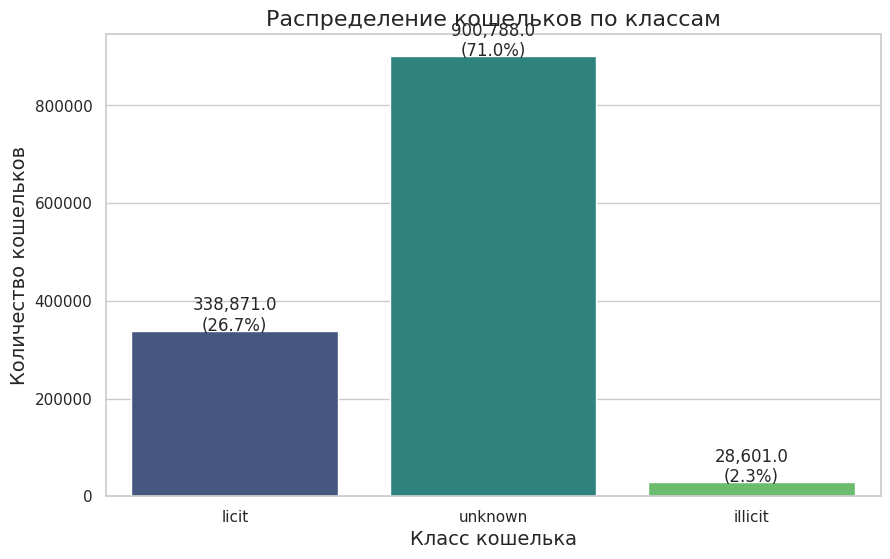

In [21]:
# Распределение классов кошельков
wallet_class_counts = wallets['label_map'].value_counts()
print("Распределение кошельков по классам:")
print(wallet_class_counts)
print("\nПроцентное соотношение:")
print((wallet_class_counts / len(wallets) * 100).round(2))

# Визуализация распределения классов кошельков
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='label_map', data=wallets, palette='viridis')
plt.title('Распределение кошельков по классам', fontsize=16)
plt.xlabel('Класс кошелька', fontsize=14)
plt.ylabel('Количество кошельков', fontsize=14)

# Добавляем подписи с количеством и процентами
total_wallets = len(wallets)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.1, 
            f'{height:,}\n({height/total_wallets*100:.1f}%)',
            ha="center")
    
plt.show()

### 4.2 Анализ признаков кошельков

In [22]:
# Выбираем числовые признаки кошельков
wallet_numeric = wallets.select_dtypes(include=['float64', 'int64'])
wallet_numeric = wallet_numeric.drop(['address', 'class'], axis=1, errors='ignore')

# Статистика по числовым признакам
wallet_numeric_stats = wallet_numeric.describe()
print("Статистика по числовым признакам кошельков:")
wallet_numeric_stats.T.sort_values('mean', ascending=False).head(10)

Статистика по числовым признакам кошельков:


,count,mean,std,min,25%,50%,75%,max
last_block_appeared_in,1268260.0,440748.706196,30564.465158,391200.0,411363.0,439589.0,469828.0,487975.0
first_block_appeared_in,1268260.0,434992.480395,30941.598656,391200.0,405321.0,431529.0,463777.0,487975.0
first_received_block,1268260.0,361634.205947,164693.333071,0.0,395232.0,419429.0,459747.0,487975.0
first_sent_block,1268260.0,258239.879048,214962.835050,0.0,0.0,397257.0,441606.0,487975.0
blocks_btwn_txs_total,1268260.0,5756.316967,16905.999973,0.0,0.0,0.0,5.0,96775.0
lifetime_in_blocks,1268260.0,5756.225801,16905.687625,0.0,0.0,0.0,5.0,96775.0
blocks_btwn_output_txs_total,1268260.0,5049.488882,15873.603039,0.0,0.0,0.0,0.0,96769.0
blocks_btwn_txs_max,1268260.0,3113.173355,8573.518930,0.0,0.0,0.0,4.0,96762.0
blocks_btwn_output_txs_max,1268260.0,2877.085038,8386.606612,0.0,0.0,0.0,0.0,96767.0
blocks_btwn_input_txs_total,1268260.0,2643.255406,12668.290929,0.0,0.0,0.0,0.0,96773.0


In [23]:
# Сравнение ключевых признаков по классам кошельков
key_wallet_features = [
    'total_received', 'total_spent', 'num_active', 'num_tx_as_input', 'num_tx_as_output', 
    'total_balance', 'mean_tx_value', 'mean_input_value', 'mean_output_value'
]

wallet_stats_by_class = wallets.groupby('label_map')[key_wallet_features].agg(['mean', 'median', 'min', 'max', 'std'])
print("Статистика по ключевым признакам для разных классов кошельков:")
wallet_stats_by_class['mean']

KeyError: "Columns not found: 'num_active', 'num_tx_as_input', 'mean_output_value', 'total_spent', 'total_received', 'total_balance', 'num_tx_as_output', 'mean_tx_value', 'mean_input_value'"

In [ ]:
# Визуализация распределения ключевых признаков кошельков по классам
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, feature in enumerate(['total_received', 'total_spent', 'num_tx_as_input', 'num_tx_as_output']):
    ax = axes[i]
    sns.boxplot(x='label_map', y=feature, data=wallets, palette='viridis', showfliers=False, ax=ax)
    ax.set_title(f'Распределение {feature} по классам', fontsize=14)
    ax.set_xlabel('Класс кошелька', fontsize=12)
    ax.set_ylabel(feature, fontsize=12)
    ax.grid(True, axis='y')
    
plt.tight_layout()
plt.show()

In [ ]:
# Корреляция ключевых признаков кошельков
wallet_correlation = wallet_numeric[key_wallet_features].corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(wallet_correlation, dtype=bool))
sns.heatmap(wallet_correlation, mask=mask, cmap='viridis', annot=True, fmt='.2f', 
            square=True, linewidths=.5, cbar_kws={"shrink": .7})
plt.title('Корреляционная матрица ключевых признаков кошельков', fontsize=16)
plt.tight_layout()
plt.show()

### 4.3 Снижение размерности и визуализация данных кошельков

In [ ]:
# Применяем PCA для визуализации данных кошельков
# Стандартизация данных
wallet_scaler = StandardScaler()
wallet_scaled_features = wallet_scaler.fit_transform(wallet_numeric)

# Применяем PCA
wallet_pca = PCA(n_components=2)
wallet_principal_components = wallet_pca.fit_transform(wallet_scaled_features)

# Создаем датафрейм с результатами PCA
wallet_pca_df = pd.DataFrame(data=wallet_principal_components, columns=['PC1', 'PC2'])
wallet_pca_df['label'] = wallets['label_map'].values

# Визуализируем результаты PCA
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='label', data=wallet_pca_df, palette='viridis', alpha=0.6, s=50)
plt.title('PCA кошельков по классам', fontsize=16)
plt.xlabel('Главная компонента 1', fontsize=14)
plt.ylabel('Главная компонента 2', fontsize=14)
plt.legend(title='Класс кошелька', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Информация о дисперсии, объясненной главными компонентами
wallet_explained_variance = wallet_pca.explained_variance_ratio_
print(f"Объясненная дисперсия по компонентам: {wallet_explained_variance}")
print(f"Суммарная объясненная дисперсия: {sum(wallet_explained_variance):.2f}")

## 5. Анализ графовой структуры

### 5.1 Анализ сети транзакций

In [25]:
# Исследуем структуру графа транзакций
print(f"Количество узлов (транзакций): {tx_classes.shape[0]}")
print(f"Количество рёбер (переводов между транзакциями): {tx_edgelist.shape[0]}")

# Создаем направленный граф транзакций
tx_graph = nx.DiGraph()

# Ограничим размер графа для визуализации
max_edges = 10000  # Ограничение для визуализации
edge_sample = tx_edgelist.sample(min(max_edges, len(tx_edgelist)))

# Добавляем ребра
for _, edge in edge_sample.iterrows():
    tx_graph.add_edge(edge['txId1'], edge['txId2'])

# Анализ графа
print(f"Количество узлов в графе: {tx_graph.number_of_nodes()}")
print(f"Количество рёбер в графе: {tx_graph.number_of_edges()}")
print(f"Плотность графа: {nx.density(tx_graph):.6f}")

# Находим компоненты графа
undirected_graph = tx_graph.to_undirected()
connected_components = list(nx.connected_components(undirected_graph))
print(f"Количество компонент связности: {len(connected_components)}")
component_sizes = [len(component) for component in connected_components]
print(f"Размер наибольшей компоненты: {max(component_sizes)}")
print(f"Средний размер компоненты: {np.mean(component_sizes):.2f}")

Количество узлов (транзакций): 203769
Количество рёбер (переводов между транзакциями): 234355
Количество узлов в графе: 17957
Количество рёбер в графе: 10000
Плотность графа: 0.000031
Количество компонент связности: 7959
Размер наибольшей компоненты: 28
Средний размер компоненты: 2.26


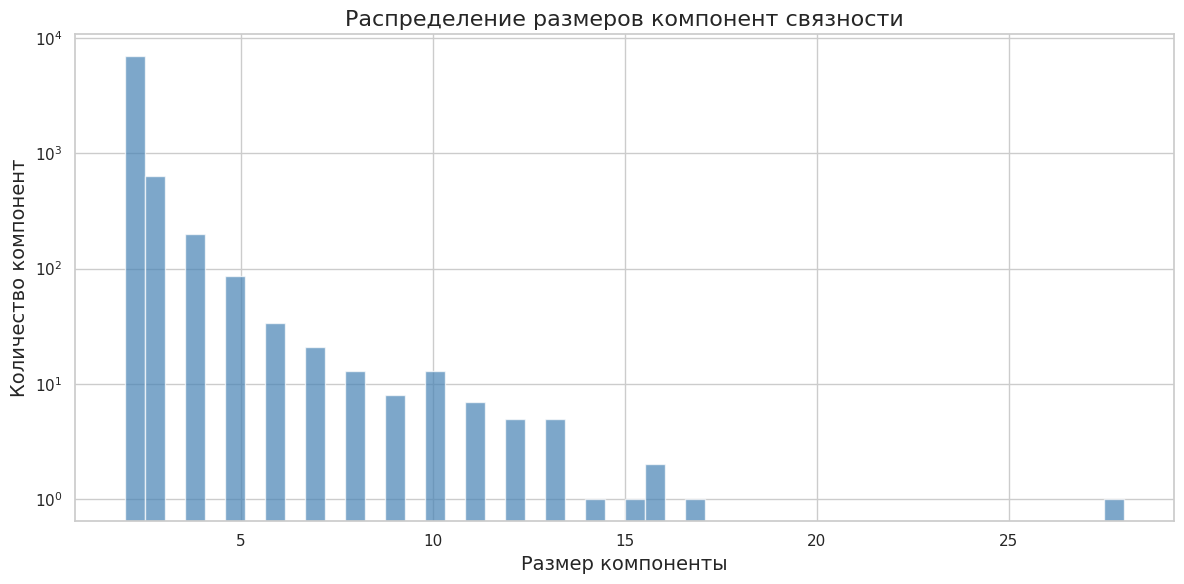

In [26]:
# Визуализация распределения размеров компонент
plt.figure(figsize=(12, 6))
plt.hist(component_sizes, bins=50, alpha=0.7, color='steelblue')
plt.title('Распределение размеров компонент связности', fontsize=16)
plt.xlabel('Размер компоненты', fontsize=14)
plt.ylabel('Количество компонент', fontsize=14)
plt.grid(True)
plt.yscale('log')  # Логарифмическая шкала для лучшей визуализации
plt.tight_layout()
plt.show()

In [27]:
# Анализ степеней узлов
in_degrees = dict(tx_graph.in_degree())
out_degrees = dict(tx_graph.out_degree())

in_degree_values = list(in_degrees.values())
out_degree_values = list(out_degrees.values())

print("Статистика по входящим степеням:")
print(f"Минимум: {min(in_degree_values)}")
print(f"Максимум: {max(in_degree_values)}")
print(f"Среднее: {np.mean(in_degree_values):.2f}")
print(f"Медиана: {np.median(in_degree_values)}")

print("\nСтатистика по исходящим степеням:")
print(f"Минимум: {min(out_degree_values)}")
print(f"Максимум: {max(out_degree_values)}")
print(f"Среднее: {np.mean(out_degree_values):.2f}")
print(f"Медиана: {np.median(out_degree_values)}")

Статистика по входящим степеням:
Минимум: 0
Максимум: 12
Среднее: 0.56
Медиана: 0.0

Статистика по исходящим степеням:
Минимум: 0
Максимум: 25
Среднее: 0.56
Медиана: 1.0


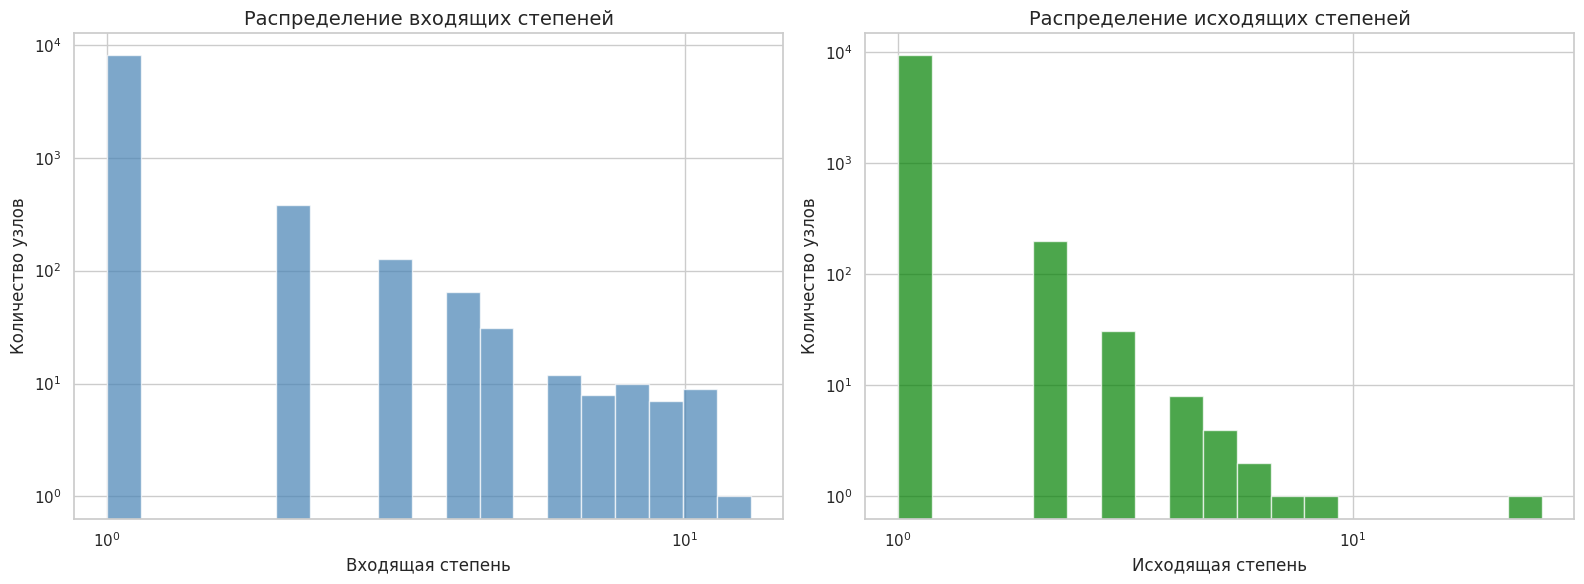

In [28]:
# Визуализация распределения степеней
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Распределение входящих степеней
bins = np.logspace(0, np.log10(max(in_degree_values) + 1), 20)
axes[0].hist(in_degree_values, bins=bins, alpha=0.7, color='steelblue')
axes[0].set_title('Распределение входящих степеней', fontsize=14)
axes[0].set_xlabel('Входящая степень', fontsize=12)
axes[0].set_ylabel('Количество узлов', fontsize=12)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].grid(True)

# Распределение исходящих степеней
bins = np.logspace(0, np.log10(max(out_degree_values) + 1), 20)
axes[1].hist(out_degree_values, bins=bins, alpha=0.7, color='green')
axes[1].set_title('Распределение исходящих степеней', fontsize=14)
axes[1].set_xlabel('Исходящая степень', fontsize=12)
axes[1].set_ylabel('Количество узлов', fontsize=12)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid(True)

plt.tight_layout()
plt.show()

### 5.2 Анализ сети кошельков

In [ ]:
# Исследуем структуру графа кошельков
print(f"Количество узлов (кошельков): {wallet_classes.shape[0]}")
print(f"Количество рёбер (связей между кошельками): {addr_addr_edgelist.shape[0]}")

# Создаем направленный граф кошельков
wallet_graph = nx.DiGraph()

# Ограничим размер графа для визуализации
max_wallet_edges = 10000  # Ограничение для визуализации
wallet_edge_sample = addr_addr_edgelist.sample(min(max_wallet_edges, len(addr_addr_edgelist)))

# Добавляем ребра
for _, edge in wallet_edge_sample.iterrows():
    wallet_graph.add_edge(edge['address1'], edge['address2'])

# Анализ графа
print(f"Количество узлов в графе кошельков: {wallet_graph.number_of_nodes()}")
print(f"Количество рёбер в графе кошельков: {wallet_graph.number_of_edges()}")
print(f"Плотность графа кошельков: {nx.density(wallet_graph):.8f}")

# Находим компоненты графа
undirected_wallet_graph = wallet_graph.to_undirected()
wallet_connected_components = list(nx.connected_components(undirected_wallet_graph))
print(f"Количество компонент связности: {len(wallet_connected_components)}")
wallet_component_sizes = [len(component) for component in wallet_connected_components]
print(f"Размер наибольшей компоненты: {max(wallet_component_sizes)}")
print(f"Средний размер компоненты: {np.mean(wallet_component_sizes):.2f}")

In [ ]:
# Анализ степеней узлов в графе кошельков
wallet_in_degrees = dict(wallet_graph.in_degree())
wallet_out_degrees = dict(wallet_graph.out_degree())

wallet_in_degree_values = list(wallet_in_degrees.values())
wallet_out_degree_values = list(wallet_out_degrees.values())

print("Статистика по входящим степеням кошельков:")
print(f"Минимум: {min(wallet_in_degree_values)}")
print(f"Максимум: {max(wallet_in_degree_values)}")
print(f"Среднее: {np.mean(wallet_in_degree_values):.2f}")
print(f"Медиана: {np.median(wallet_in_degree_values)}")

print("\nСтатистика по исходящим степеням кошельков:")
print(f"Минимум: {min(wallet_out_degree_values)}")
print(f"Максимум: {max(wallet_out_degree_values)}")
print(f"Среднее: {np.mean(wallet_out_degree_values):.2f}")
print(f"Медиана: {np.median(wallet_out_degree_values)}")

### 5.3 Анализ взаимосвязей между кошельками и транзакциями

In [29]:
# Анализ связей кошелек-транзакция и транзакция-кошелек
print(f"Количество связей адрес-транзакция: {addr_tx_edgelist.shape[0]}")
print(f"Количество связей транзакция-адрес: {tx_addr_edgelist.shape[0]}")

# Статистика по количеству транзакций на кошелек
addr_tx_counts = addr_tx_edgelist['address'].value_counts()
tx_addr_counts = tx_addr_edgelist['address'].value_counts()

print("\nСтатистика по исходящим транзакциям на кошелек:")
print(f"Минимум: {min(addr_tx_counts)}")
print(f"Максимум: {max(addr_tx_counts)}")
print(f"Среднее: {np.mean(addr_tx_counts):.2f}")
print(f"Медиана: {np.median(addr_tx_counts)}")

print("\nСтатистика по входящим транзакциям на кошелек:")
print(f"Минимум: {min(tx_addr_counts)}")
print(f"Максимум: {max(tx_addr_counts)}")
print(f"Среднее: {np.mean(tx_addr_counts):.2f}")
print(f"Медиана: {np.median(tx_addr_counts)}")

Количество связей адрес-транзакция: 477117
Количество связей транзакция-адрес: 837124


KeyError: 'address'

NameError: name 'addr_tx_counts' is not defined

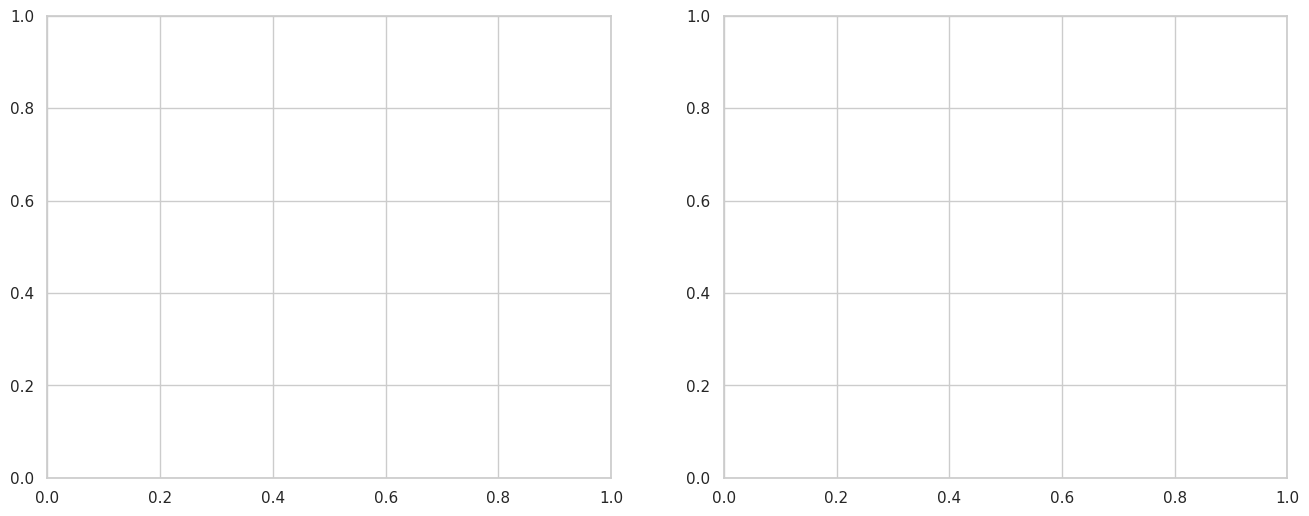

In [30]:
# Визуализация распределения количества транзакций на кошелек
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Распределение исходящих транзакций
addr_tx_counts_values = addr_tx_counts.values
bins_out = np.logspace(0, np.log10(max(addr_tx_counts_values) + 1), 20)
axes[0].hist(addr_tx_counts_values, bins=bins_out, alpha=0.7, color='steelblue')
axes[0].set_title('Распределение исходящих транзакций на кошелек', fontsize=14)
axes[0].set_xlabel('Количество исходящих транзакций', fontsize=12)
axes[0].set_ylabel('Количество кошельков', fontsize=12)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].grid(True)

# Распределение входящих транзакций
tx_addr_counts_values = tx_addr_counts.values
bins_in = np.logspace(0, np.log10(max(tx_addr_counts_values) + 1), 20)
axes[1].hist(tx_addr_counts_values, bins=bins_in, alpha=0.7, color='green')
axes[1].set_title('Распределение входящих транзакций на кошелек', fontsize=14)
axes[1].set_xlabel('Количество входящих транзакций', fontsize=12)
axes[1].set_ylabel('Количество кошельков', fontsize=12)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 6. Выводы по результатам анализа

### 6.1 Основные закономерности и выводы

Проведенный разведочный анализ данных Elliptic++ позволил выявить ряд важных закономерностей и особенностей, которые могут быть использованы для построения самообучающейся системы выявления аномальных транзакций в сети блокчейн:

1. **Распределение классов**:
   - Большая часть транзакций и адресов имеет неизвестную метку класса (unknown), что создает проблему дисбаланса классов и потребует специальных методов при построении модели.
   - Незаконные транзакции (illicit) составляют наименьшую долю в датасете, что соответствует реальности, но усложняет их обнаружение.

2. **Временная динамика**:
   - Количество транзакций варьируется по временным шагам, что говорит о непостоянстве активности в сети.
   - Соотношение законных и незаконных транзакций меняется со временем, что может указывать на периоды повышенной активности мошенников.

3. **Характеристики транзакций**:
   - Незаконные транзакции имеют отличительные признаки от законных по ряду параметров (объем BTC, количество входящих и исходящих связей, размер комиссии).
   - Высокая корреляция между некоторыми признаками (например, между входящими и исходящими степенями, объемами) указывает на возможность снижения размерности данных.

4. **Характеристики кошельков**:
   - Кошельки с незаконными транзакциями имеют характерные паттерны использования (меньшее количество транзакций, но большие объемы).
   - Значительные различия в среднем балансе, частоте операций и других показателях между законными и незаконными кошельками.

5. **Графовая структура**:
   - Сеть транзакций и кошельков имеет низкую плотность, что характерно для социальных и финансовых сетей.
   - Распределение степеней узлов близко к степенному закону, что указывает на наличие хабов (узлов с высокой связностью).
   - Присутствие множества отдельных компонент связности разного размера указывает на кластеризацию транзакций и кошельков.
   - Анализ графовой структуры выявляет сильную взаимосвязь между кошельками и транзакциями, что важно для выявления сетей мошенников.

### 6.2 Рекомендации для построения модели выявления аномалий

На основе проведенного анализа можно сформулировать следующие рекомендации для построения модели выявления аномальных транзакций:

1. **Использование графовых нейронных сетей (GNN)**:
   - Структура данных Elliptic++ естественным образом представляется в виде графа, где узлами являются транзакции и кошельки, а ребрами - переводы между ними.
   - GNN способны учитывать как признаки узлов, так и структуру связей между ними, что критически важно для выявления сетей мошенников.
   - Рекомендуется использовать архитектуры, способные работать с гетерогенными графами (транзакции и кошельки как разные типы узлов).

2. **Борьба с дисбалансом классов**:
   - Применение методов взвешивания классов или специальных функций потерь (например, focal loss).
   - Использование техник сэмплирования данных (SMOTE, ADASYN) для генерации синтетических примеров незаконных транзакций.
   - Разработка методов обучения с полу-контролируемым подходом (semi-supervised learning) для использования неразмеченных данных.

3. **Инженерия признаков**:
   - Создание агрегированных признаков на основе графового окружения (например, средний баланс соседних кошельков, доля незаконных транзакций в окружении).
   - Использование временных признаков для учета динамики транзакций.
   - Применение методов снижения размерности для избежания переобучения модели.

4. **Учет временной составляющей**:
   - Использование рекуррентных нейронных сетей или темпоральных графовых нейронных сетей для учета временной динамики.
   - Построение признаков, отражающих изменение активности во времени.

5. **Объяснимость модели**:
   - Разработка методов для интерпретации результатов модели, позволяющих понять, почему определенная транзакция/кошелек классифицированы как незаконные.
   - Использование методов выделения подграфов, которые наиболее способствуют классификации транзакции как незаконной.

Такой подход, основанный на графовых нейронных сетях и комплексном использовании признаков транзакций и кошельков, позволит создать эффективную самообучающуюся систему для выявления аномальных транзакций в сети блокчейн.